## Neural Network Classification with Pytorch

In [ ]:
from sklearn.datasets import make_circles

n_samples = 1000

X,y = make_circles(n_samples, noise=0.15, random_state=42)

In [ ]:
#Make Dataframe of circles data
import pandas as pd
circles = pd.DataFrame({'X1': X[:, 0],
                       'X2': X[:, 1],
                      "label": y})
circles.head()

In [ ]:
# Vizualize
import matplotlib.pyplot as plt
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu)

### Check Input and Output shapes

In [ ]:
X.shape?
X.shape, y.shape

In [ ]:
X_sample = X[0]
y_sample = y[0]
print(X_sample, y_sample)

In [ ]:
# Turn Data into Tensors
import torch
torch.__version__

In [ ]:
type(X)

In [ ]:
X=torch.from_numpy(X).type(torch.float)
y=torch.from_numpy(y).type(torch.float)

In [ ]:
X.dtype, y.dtype

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42) 

In [ ]:
len(X_train), len(X_test), len(y_train), len(y_test)

## Building a Model

In [ ]:
import torch
import torch.nn as nn
device = "cuda" if torch.cuda.is_available else "cpu"

In [ ]:
device

### Setup device agnostic code

### 3 ways to create a Model

In [ ]:
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        # way 1
        # self.layer_1 = nn.Linear(in_features=2, out_features=5) # it takes 2 features from X and upscale to 5 feature
        # self.layer_2 = nn.Linear(in_features=5, out_features=1)

        # way 2
        self.two_linear_layers = nn.Sequential(
            nn.Linear(in_features=2, out_features=5),
            nn.Linear(in_features=5, out_features=1)
        )
        
    def forward(self, x):
        # return self.layer_2(self.layer_1(x)) # X_train -> layer_1 -> layer_2 -> output
        return self.two_linear_layers(x)

model_0 = CircleModelV0().to(device)

In [ ]:
model_0

it take 2 features initially and  performs nn.Linear(y=xAT+b) and upscales to 5 features

In [ ]:
next(model_0.parameters()).device

In [ ]:
# way 3
model_1 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)
model_1

In [ ]:
model_0.state_dict()

In [ ]:
# Make Prediction
with torch.inference_mode():
    untrained_preds = model_0(X_test.to(device))
print(f'Length of Prediction: {len(untrained_preds)} and Shape is {untrained_preds.shape}')
print(f'\nFirst 10 predictions {untrained_preds[:10]}')
print(f'\nFirst 10 labels: {(y_test[:10])}')

## Setting Up a Loss Function
### For the Loss Funtion, we're going to use BCEWithLogitLoss (here Logit is referred as Layer which gives denormalized log probabilities of output), basically, In Logit Layer, when an input passed throught softmax such layer comes as normalized i.e, ranges betn 0 & 1 but 

basically, it's better to use softmaxWithLogitLoss for training and softmax for evaluation

BCE = Binary cross entropy loss
use Cross Entropy for multiclass classification

In [ ]:
# setup the loss function
# loss_fn = nn.BCELoss() # requires to pass through Sigmoid activation function prior to input the BCELoss
# BCEWithLogitsLoss is better numerically stablized than doing 
# loss_fn = nn.Sequential(
#     nn.Sigmoid(),
#     nn.BCELoss()
# )
loss_fn = nn.BCEWithLogitsLoss()
optim = torch.optim.SGD(params=model_0.parameters(),
                       lr=0.1)

In [ ]:
# calculate accuracy
def accuracy(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct/len(y_pred)) * 100
    return acc

## Train the model from training loop
### Going from raw logits -> prediction probabilities -> prediction labels
In our context, logits are raw output of our model

In [ ]:
with torch.inference_mode():
    y_logits = model_0(X_test.to(device))
y_logits[:5], y_test[:5]

In [ ]:
#use sigmoid activation to convert raw logits into predictions probabilities
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs[:5], torch.round(y_pred_probs[:5])

In [ ]:
y_preds = torch.round(y_pred_probs)
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))))
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))
y_preds.squeeze()

In [ ]:
y_pred_labels

In [ ]:
y_preds[:5], y_test[:5].to(device)

In [ ]:
!nvidia-smi

## Building the training and testing loop

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42) # set when reproducibility should be in code written for cuda/gpu

epochs=100

X_train, X_test = X_train.to(device), X_test.to(device)
y_train, y_test = y_train.to(device), y_test.to(device)

# Building training and evaluation loop
for epoch in range(epochs):
    model_0.train()

    # Forward Pass
    y_logits = model_0(X_train).squeeze()
    y_preds = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labels

    # Calculate the Loss
    loss = loss_fn(y_logits, # nn.BCEWithLogitsLoss expects raw logits as input while nn.BCE expects pred probs by sigmoid as input
                  y_train)
    acc = accuracy(y_train, y_preds)

    # Optimize the zero grad
    optim.zero_grad()

    # Loss Backward Propagation
    loss.backward()

    # Optimizer step 
    optim.step()

    ### Testing
    model_0.eval()
    with torch.inference_mode():
        # forward pass
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        # calculate the loss
        test_loss = loss_fn(test_logits,
                           y_test)
        test_acc = accuracy(y_test, test_pred)

    if epoch%10 == 0:
        print(f'Epoch: {epoch} | Loss: {loss:.2f}%, Acc: {acc:.2f} | Test Loss: {test_loss:.2f}%, Test Acc: {test_acc:.2f}')

In [ ]:
import requests
from pathlib import Path 

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

In [ ]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

In [ ]:
plot_decision_boundary?

### Improving a model
* Add more layers - giving them more chances to learn on more patterns
* Add more hidden units
* Fit for longer - More Epochs, Low learning rate
* Changing the activation function
* Change the learning rate (best=0.01)
* Change the loss function

In [ ]:
class CircleModelV11(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2,out_features=10),
        self.layer_2 = nn.Linear(in_features=10,out_features=10),
        self.layer_3 = nn.Linear(in_features=10,out_features=1)

    def forward(self, x):
        return self.layer_3(self.layer_2(self.layer_1(x)))

In [ ]:
class CircleModelV1(nn.Sequential):
    def __init__(self):
        super().__init__()
        self.multi_layers = nn.Sequential(
            nn.Linear(in_features=2,out_features=10),
            nn.Linear(in_features=10,out_features=10),
            nn.Linear(in_features=10,out_features=1)
        )

    def forward(self, x):
        return self.multi_layers(x)

* nn.Module for more complex and modular units
* nn.Sequential for simplier and small units

In [ ]:
model_1 = CircleModelV1().to(device)
model_1

In [ ]:
loss_fn = nn.BCEWithLogitsLoss()
optim = torch.optim.Adam(params=model_1.parameters(), lr=0.01)

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 1000

X_train, X_test, y_train, y_test = X_train.to(device), X_test.to(device), y_train.to(device), y_test.to(device)

for epoch in range(epochs):
    model_1.train()

    # Forward Pass
    y_logits = model_1(X_train).squeeze()
    y_preds = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labels

    # Calculate the Loss
    loss = loss_fn(y_logits, # nn.BCEWithLogitsLoss expects raw logits as input while nn.BCE expects pred probs by sigmoid as input
                  y_train)
    acc = accuracy(y_train, y_preds)

    # Optimize the zero grad
    optim.zero_grad()

    # Loss Backward Propagation
    loss.backward()

    # Optimizer step 
    optim.step()

    ### Testing
    model_0.eval()
    with torch.inference_mode():
        # forward pass
        test_logits = model_1(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        # calculate the loss
        test_loss = loss_fn(test_logits,
                           y_test)
        test_acc = accuracy(y_test, test_pred)

    if epoch%100 == 0:
        print(f'Epoch: {epoch} | Loss: {loss:.2f}%, Acc: {acc:.2f} | Test Loss: {test_loss:.2f}%, Test Acc: {test_acc:.2f}')

In [ ]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

### It still gives bad result🥲
### Let's Add Non-linearity in our model

In [ ]:
from sklearn.datasets import make_circles
n_samples =1000
X, y = make_circles(n_samples, noise=0.03, random_state=42)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu)

In [ ]:
import torch
from sklearn.model_selection import train_test_split

X = torch.from_numpy(X).type(torch.float32)
y = torch.from_numpy(y).type(torch.float32)

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)


### 4th Way to create an DL model

In [ ]:
from collections import OrderedDict
from torch.nn import Sequential
from torch.nn import ReLU, Dropout, Linear

model_2 = Sequential(OrderedDict([
         ('layer1', nn.Linear(in_features=2, out_features=10)),
         ('relu1', nn.ReLU()),
         ('layer2', nn.Linear(in_features=10, out_features=10)),
         ('relu2', nn.ReLU()),
         ('layer3', nn.Linear(in_features=10, out_features=1)),
])).to(device)
model_2

In [ ]:
model_2.to(device)

In [ ]:
# Make Prediction
with torch.inference_mode():
    untrained_preds = model_2(X_test.to(device)).to(device)
print(f'Length of Prediction: {len(untrained_preds)} and Shape is {untrained_preds.shape}')
print(f'\nFirst 10 predictions {untrained_preds[:10]}')
print(f'\nFirst 10 labels: {(y_test[:10])}')

In [ ]:
loss_fn = nn.BCEWithLogitsLoss()
optim = torch.optim.SGD(model_2.parameters(), 0.1)

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
epochs = 1000

X_train, X_test, y_train, y_test = X_train.to(device), X_test.to(device), y_train.to(device), y_test.to(device)

for epoch in range(epochs):
    model_2.train()

    # Forward Pass
    y_logits = model_2(X_train).squeeze()
    y_preds = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labels

    # Calculate the Loss
    loss = loss_fn(y_logits, # nn.BCEWithLogitsLoss expects raw logits as input while nn.BCE expects pred probs by sigmoid as input
                  y_train)
    acc = accuracy(y_train, y_preds)

    # Optimize the zero grad
    optim.zero_grad()

    # Loss Backward Propagation
    loss.backward()

    # Optimizer step 
    optim.step()

    ### Testing
    model_2.eval()
    with torch.inference_mode():
        # forward pass
        test_logits = model_2(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        # calculate the loss
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy(y_test, test_pred)

    if epoch%100 == 0:
        print(f'Epoch: {epoch} | Loss: {loss:.2f}%, Acc: {acc:.2f} | Test Loss: {test_loss:.2f}%, Test Acc: {test_acc:.2f}')


## Evaluating the model with Non-Linear Activation Function

In [ ]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_2, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_2, X_test, y_test)

In [ ]:
model_2.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(X_test)).squeeze()
y_preds[:10], y_test[:10]

In [ ]:
# Miscelleneous 
a = torch.arange(-5,5)
b = torch.arange(5,5)
a_new = torch.relu(a)
b_new = torch.sigmoid(b)
plt.plot(a_new)

## Now, Time for best possible model I can make

In [ ]:
from torch.nn import Sequential
from collections import OrderedDict
from torch.nn import Linear, Dropout, ReLU, Sigmoid

model_3 = Sequential(OrderedDict([
    ('input_layer', Linear(in_features=2, out_features=10)),
    ('activate_relu1', ReLU()),
    # ('dropout1', Dropout(0.3)),
    ('hidden_layer1', Linear(in_features=10,out_features=10)),
    ('activate_relu2', ReLU()),
    # ('hidden_layer2', Linear(in_features=10,out_features=10)),
    ('activate_relu3', ReLU()),
    ('hidden_layer4', Linear(in_features=10,out_features=1)),
])).to(device)
model_3

## Implement early stopping

In [ ]:
class EarlyStopping:
    def __init__(self, patience=20, min_delta=0.0001):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = float('inf')
        self.counter = 0

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1

        if self.counter >= self.patience:
            return True  # Stop training
        return False

early_stopping = EarlyStopping()


In [ ]:
loss_fn = nn.BCEWithLogitsLoss()
optim = torch.optim.SGD(model_3.parameters(), 0.1)

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
epochs = 1200

X_train, X_test, y_train, y_test = X_train.to(device), X_test.to(device), y_train.to(device), y_test.to(device)

for epoch in range(epochs):
    model_3.train()

    # Forward Pass
    y_logits = model_3(X_train).squeeze()
    y_preds = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labels

    # Calculate the Loss
    loss = loss_fn(y_logits, # nn.BCEWithLogitsLoss expects raw logits as input while nn.BCE expects pred probs by sigmoid as input
                  y_train)
    acc = accuracy(y_train, y_preds)

    # Optimize the zero grad
    optim.zero_grad()

    # Loss Backward Propagation
    loss.backward()

    # Optimizer step 
    optim.step()

    ### Testing
    model_3.eval()
    with torch.inference_mode():
        # forward pass
        test_logits = model_3(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        # calculate the loss
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy(y_test, test_pred)

    if epoch%100 == 0:
        print(f'Epoch: {epoch} | Loss: {loss:.2f}%, Acc: {acc:.2f} | Test Loss: {test_loss:.2f}%, Test Acc: {test_acc:.2f}')


In [ ]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_3, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test)

In [ ]:
model_3.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(X_test)).squeeze()
y_preds[:10], y_test[:10]

# Working with multiclass dataset

### Creating toy dataset

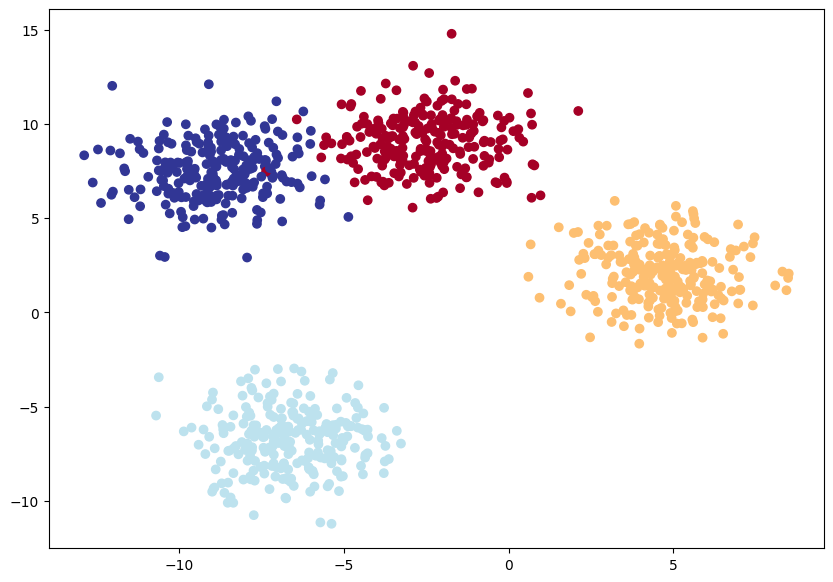

In [173]:
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

X_blob, y_blob = make_blobs(n_samples=1000, n_features=NUM_FEATURES,
                           centers=NUM_CLASSES, cluster_std=1.5,
                            random_state=RANDOM_SEED)

X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob, y_blob, test_size=0.33, random_state=RANDOM_SEED)

# Plotting data
plt.figure(figsize=(10,7))
plt.scatter(X_blob[:,0], X_blob[:,1], c=y_blob, cmap=plt.cm.RdYlBu)

## Building multiclass classification model

In [257]:
# create device agnostic code
device = 'cuda' if torch.cuda.is_available else  'cpu'

from collections import OrderedDict
import torch.nn as nn

# building model
class BlobModel(nn.Module):
    def __init__(self, in_features, out_features, hidden_units=11):
        """Initialize multiclass classification model
        
        Args:
        in_features (int): Number of input features to the model
        out_features (int): Number of output features to the model
        hidden_units (int): Number of hidden units inbetween the layers
        
        Returns: nn.Sequential()
        
        Example:
        """
        super().__init__()
        self.linear_layer_stack = nn.Sequential(OrderedDict([
            ('input_layer', nn.Linear(in_features=in_features, out_features=hidden_units)),
            ('relu1', nn.ReLU()),
            ('hidden_layer', nn.Linear(in_features=hidden_units, out_features=hidden_units)),
            ('dropout_layer', nn.Dropout(p=0.33)),
            ('hidden_layer2', nn.Linear(in_features=hidden_units, out_features=hidden_units)),
            ('relu2', nn.ReLU()),
            ('output_layer', nn.Linear(in_features=hidden_units, out_features=out_features)),
        ]))

    def forward(self, x):
        return self.linear_layer_stack(x)

In [258]:
model_4 = BlobModel(in_features=NUM_FEATURES, out_features=NUM_CLASSES).to(device)
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (input_layer): Linear(in_features=2, out_features=11, bias=True)
    (relu1): ReLU()
    (hidden_layer): Linear(in_features=11, out_features=11, bias=True)
    (dropout_layer): Dropout(p=0.33, inplace=False)
    (hidden_layer2): Linear(in_features=11, out_features=11, bias=True)
    (relu2): ReLU()
    (output_layer): Linear(in_features=11, out_features=4, bias=True)
  )
)

In [259]:
X_blob_train.shape, y_blob_train.shape

(torch.Size([670, 2]), torch.Size([670]))

In [260]:
X_blob_train

tensor([[-8.6610, -6.4154],
        [-6.5993,  6.9168],
        [-6.8887, -5.6224],
        ...,
        [-1.7366,  9.7850],
        [-6.8139, -7.1006],
        [-9.0311,  4.5007]], device='cuda:0')

In [261]:
torch.unique(y_blob)

tensor([0, 1, 2, 3])

* loss func === criterion === cost func
* For Inbalanced Dataset like credit card fraud, nn.CrossEntropyLoss(weight) set weight arg

### *In Order to evaluate and train our model, we have to convert our model's output(logits) into prediction probabilites and then into prediction labels

In [262]:
# creating loss function and optimizers
loss_fn = nn.CrossEntropyLoss()
optim = torch.optim.Adam(params=model_4.parameters(), lr=0.01)

In [263]:
next(model_4.parameters()).device, X_blob_test.device

(device(type='cuda', index=0), device(type='cuda', index=0))

In [264]:
# getting prediction probability or raw output from our model
model_4.eval()
with torch.inference_mode():
    y_logtis = model_4(X_blob_train.to(device))
model_4(X_blob_train.to(device))[:5], y_blob_train[:5]

(tensor([[ 0.3236, -0.2613,  0.5788, -0.9059],
         [ 0.6003, -0.3927,  0.7814, -1.0756],
         [ 0.1992, -0.2254,  0.4686, -0.7302],
         [-0.3265, -0.1193,  0.0788, -0.2719],
         [ 0.7774, -0.4698,  0.8795, -1.1853]], device='cuda:0',
        grad_fn=<SliceBackward0>),
 tensor([2, 3, 2, 1, 3], device='cuda:0'))

In [265]:
# prediction probabibitlies to prediction label
y_pred = torch.argmax(y_pred_probs,dim=1)
y_pred[:5], y_blob_test[:5]

(tensor([1, 3, 2, 1, 0], device='cuda:0'),
 tensor([1, 3, 2, 1, 0], device='cuda:0'))

## Setting up a training and testing loop

In [266]:
epochs = 1000

X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):
    model_4.train()
    y_logits = model_4(X_blob_train)
    y_pred =  torch.softmax(y_logits, dim=1).argmax(dim=1)
    loss = loss_fn(y_logits, y_blob_train)
    acc = accuracy(y_true=y_blob_train, y_pred=y_pred)
    optim.zero_grad()
    loss.backward()
    optim.step()

    ### Testing
    model_4.eval()
    with torch.inference_mode():
        test_logits = model_4(X_blob_test)
        test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)
        test_loss = loss_fn(test_logits, y_blob_test)
        test_acc = accuracy(y_true=y_blob_test, y_pred=test_preds)

    if epoch%100 == 0:
        print(f'Epoch: {epoch} | Loss: {loss:.2f}%, Acc: {acc:.2f} | Test Loss: {test_loss:.2f}%, Test Acc: {test_acc:.2f}')


Epoch: 0 | Loss: 1.62%, Acc: 27.31 | Test Loss: 1.40%, Test Acc: 36.36
Epoch: 100 | Loss: 0.03%, Acc: 99.25 | Test Loss: 0.01%, Test Acc: 99.09
Epoch: 200 | Loss: 0.03%, Acc: 99.25 | Test Loss: 0.01%, Test Acc: 99.39
Epoch: 300 | Loss: 0.02%, Acc: 99.40 | Test Loss: 0.01%, Test Acc: 99.70
Epoch: 400 | Loss: 0.02%, Acc: 99.25 | Test Loss: 0.01%, Test Acc: 99.70
Epoch: 500 | Loss: 0.03%, Acc: 98.96 | Test Loss: 0.01%, Test Acc: 99.70
Epoch: 600 | Loss: 0.02%, Acc: 99.40 | Test Loss: 0.01%, Test Acc: 99.70
Epoch: 700 | Loss: 0.02%, Acc: 99.55 | Test Loss: 0.01%, Test Acc: 99.70
Epoch: 800 | Loss: 0.02%, Acc: 99.25 | Test Loss: 0.01%, Test Acc: 99.70
Epoch: 900 | Loss: 0.01%, Acc: 99.40 | Test Loss: 0.01%, Test Acc: 99.70


In [267]:
model_4.eval()
with  torch.inference_mode():
    y_logits = model_4(X_blob_test)
y_logtis[:10], y_blob_test

(tensor([[ 0.3236, -0.2613,  0.5788, -0.9059],
         [ 0.6003, -0.3927,  0.7814, -1.0756],
         [ 0.1992, -0.2254,  0.4686, -0.7302],
         [-0.3265, -0.1193,  0.0788, -0.2719],
         [ 0.7774, -0.4698,  0.8795, -1.1853],
         [-0.3428, -0.1382,  0.0886, -0.2989],
         [-0.3288, -0.1137,  0.0710, -0.2403],
         [-0.3282, -0.1257,  0.0835, -0.2865],
         [-0.3241, -0.1147,  0.0764, -0.2670],
         [ 0.1791, -0.2583,  0.4645, -0.7872]], device='cuda:0'),
 tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0, 0, 1, 0, 0, 0, 3, 3, 2, 3, 3, 3, 0, 1, 2,
         2, 2, 3, 0, 1, 0, 3, 1, 1, 3, 1, 2, 1, 3, 0, 2, 0, 3, 3, 2, 0, 3, 1, 1,
         0, 3, 1, 0, 1, 1, 3, 2, 1, 1, 3, 2, 2, 0, 3, 2, 2, 0, 0, 3, 3, 0, 0, 3,
         3, 3, 2, 3, 3, 3, 3, 1, 0, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 1, 3, 3, 3,
         1, 0, 3, 2, 0, 0, 3, 0, 2, 3, 1, 0, 3, 2, 1, 1, 0, 2, 2, 3, 0, 0, 1, 2,
         2, 3, 0, 1, 2, 0, 0, 0, 2, 3, 1, 2, 3, 2, 0, 3, 0, 0, 1, 1, 1, 0, 2, 2,
         2, 2, 0, 3, 3, 2

In [276]:
# Turn predicted logits in prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)

# Turn prediction probabilities into prediction labels
y_preds = y_pred_probs.argmax(dim=1)

# Compare first 10 model preds and test labels
print(f"Predictions: {y_preds[:10]}\nLabels: {y_blob_test[:10]}")
print(f"Test accuracy: {accuracy(y_true=y_blob_test, y_pred=y_preds)}%")

Predictions: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')
Labels: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')
Test accuracy: 99.69696969696969%


### Evaluating By Visualizing

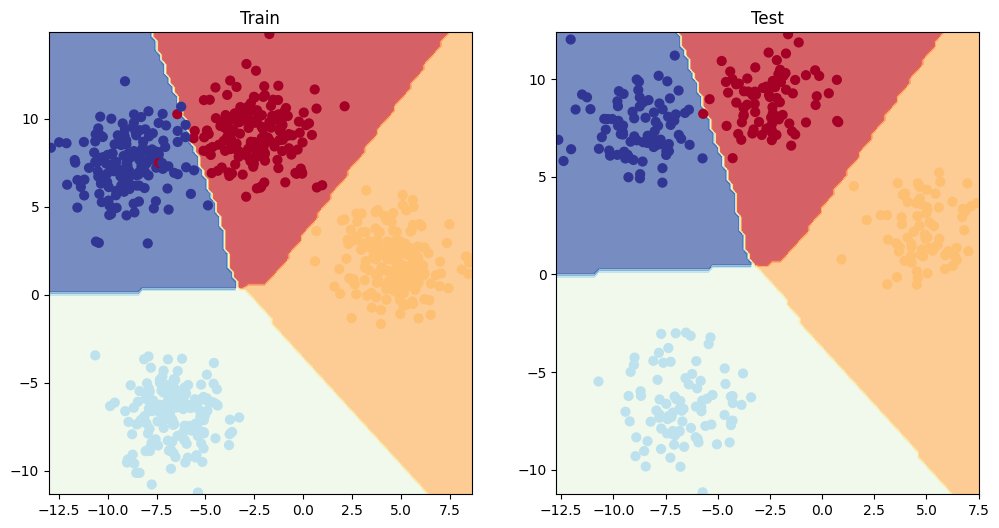

In [270]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title('Train')
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1,2,2)
plt.title('Test')
plot_decision_boundary(model_4, X_blob_test, y_blob_test)


In [271]:
model_4.state_dict()

OrderedDict([('linear_layer_stack.input_layer.weight',
              tensor([[-0.5055,  0.7598],
                      [-0.5153, -0.0199],
                      [ 0.9979,  0.6078],
                      [-0.6962, -0.2104],
                      [-0.3492,  0.3839],
                      [-0.9135, -0.3614],
                      [-0.4869,  0.5828],
                      [ 0.7824,  0.4309],
                      [ 1.0997, -0.4506],
                      [-0.3236, -0.9797],
                      [ 0.4519,  0.1090]])),
             ('linear_layer_stack.input_layer.bias',
              tensor([ 0.0056, -1.7275,  1.7128, -1.1624, -1.2409, -0.6345, -1.0414, -0.1362,
                       1.9593,  0.0757,  1.6830])),
             ('linear_layer_stack.hidden_layer.weight',
              tensor([[ 3.4172e-01,  5.9943e-02,  1.3616e-02, -4.5105e-02,  3.1404e-01,
                       -1.3645e-01,  3.3749e-01, -2.6211e-01, -6.5165e-01, -6.1277e-02,
                       -1.8693e-01],
            

In [272]:
%pip install torchmetrics

Note: you may need to restart the kernel to use updated packages.


In [278]:
from torchmetrics import Accuracy

torchmetric_acc = Accuracy(task='multiclass', num_classes=NUM_CLASSES).to(device)

torchmetric_acc(y_preds, y_blob_test)

tensor(0.9970, device='cuda:0')

In [ ]:
y_preds.shape, y_blob_test.shape

In [250]:
Accuracy?

Init signature:
Accuracy(
    task: Literal['binary', 'multiclass', 'multilabel'],
    threshold: float = 0.5,
    num_classes: Optional[int] = None,
    num_labels: Optional[int] = None,
    average: Optional[Literal['micro', 'macro', 'weighted', 'none']] = 'micro',
    multidim_average: Literal['global', 'samplewise'] = 'global',
    top_k: Optional[int] = 1,
    ignore_index: Optional[int] = None,
    validate_args: bool = True,
    **kwargs: Any,
) -> torchmetrics.metric.Metric
Docstring:     
Compute `Accuracy`_.

.. math::
    \text{Accuracy} = \frac{1}{N}\sum_i^N 1(y_i = \hat{y}_i)

Where :math:`y` is a tensor of target values, and :math:`\hat{y}` is a tensor of predictions.

This module is a simple wrapper to get the task specific versions of this metric, which is done by setting the
``task`` argument to either ``'binary'``, ``'multiclass'`` or ``'multilabel'``. See the documentation of
:class:`~torchmetrics.classification.BinaryAccuracy`, :class:`~torchmetrics.classification.M